# Why does my parallel code take much more time than a non-paralleled one?

This question is often asked among scientists. Let's say you have a function that takes a list of numbers and returns another list of the numbers, what could be the best way to parallelize this function?

In [1]:
from math import sqrt

%timeit [sqrt(i ** 2) for i in range(1_000_000)]

133 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
from math import sqrt
from joblib import Parallel, delayed

%timeit Parallel(n_jobs=4)(delayed(sqrt)(i ** 2) for i in range(1_000_000))

3.32 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 3.32 s ± 305 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [3]:
from multiprocessing import Pool

%timeit Pool().map(sqrt, range(1_000_000))

230 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
from multiprocessing.pool import ThreadPool

%timeit ThreadPool().map(sqrt, range(1_000_000))

77.8 ms ± 4.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# What is parallelism?

In the context of scientific analysis, parallelism refers to the ability to perform multiple calculations at the same time. This can be achieved by using multiple processors or cores, or by dividing the calculations into smaller independent tasks and assigning them to different processors or cores. Parallelism can significantly speed up the time it takes to perform scientific analyses, such as simulations, data analysis, and machine learning.

Parallelism is not easy, and so not only does it take substantial developer time (the time it takes you to implement it), but there are computer-time costs to breaking down problems, distributing them, and recombining them, often limiting the returns you will see to parallelism.

```{tip}
Parallelism is the process of:

1. taking a single problem,
2. breaking it into lots of smaller problems,
3. assigning those smaller problems to a number of processing cores that are able to operate independently, and
4. recombining the results.
```

# Limitations of parallelisation: Amdahl's law

There are a number of challenges associated with parallelism, such as ensuring that the different processors or cores are able to communicate with each other efficiently, and avoiding race conditions where the results of one calculation are affected by the results of another calculation. However, the benefits of parallelism can outweigh the challenges, and it is an increasingly important tool for scientific analysis.

Amdahl’s Law describes the theoretical limits of parallelization. If $P$ is the proportion of your algorithm that can be parallelized, and $N$ is the number of cores available, the fundamental limit to the speed-up you can get from parallelization is given by:
$$\begin{aligned}\textrm{total speed up} &= \frac{T_1}{T_N} \\ &= \frac{1}{\frac{P}{N} + (1 - P)} \\&\leq \frac{1}{1-P}\end{aligned}$$

This analysis neglects other potential bottlenecks such as memory bandwidth and I/O bandwidth. If these resources do not scale with the number of processors, then merely adding processors provides even lower returns.

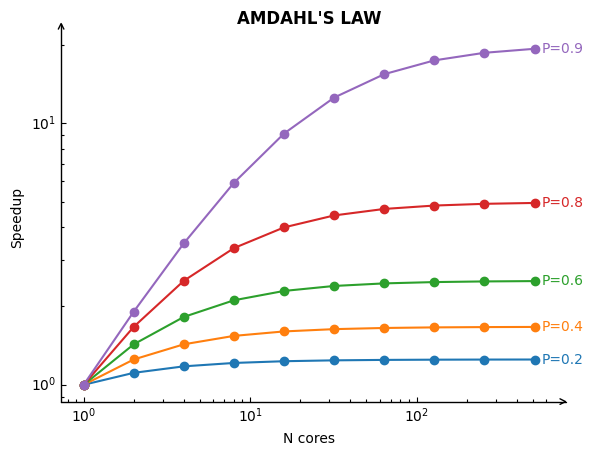

In [5]:
%matplotlib inline
import pylab as plt
import numpy as np
from mpl_toolkits.axisartist.axislines import AxesZero

P = np.array([0.2, 0.4, 0.6, 0.8, 0.95])
N = np.array([2 ** k for k in range(10)])

S_N = 1 / ((1 - P[:, None]) + P[:, None] / N[None, :])

plt.figure()
plt.subplot(axes_class=AxesZero)

for pk, snk in zip(P, S_N):
    color = plt.plot(N, snk, 'o-')[0].get_color()
    plt.text(N[-1] * 1.1, snk[-1], f'P={pk:0.1f}', va='center', color=color)

ax =  plt.gca()
for direction in ["bottom", "left"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_axisline_style("->")
for direction in ["top", "right"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_visible(False)
plt.title("Amdahl's Law".upper(), fontsize='large', fontweight='bold')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N cores')
plt.ylabel('Speedup');

For example, if a task can be parallelized 80% (red curve above) of the time and there are 4 processors, the maximum speedup would be 16. This means that the task could be completed in 1/16th of the time it would take to run on a single processor.
However, the Amdahl's law shows that there is a limit to the speedup that can be achieved, no matter how many processors are used. This is because there will always be some part of the task that must be executed sequentially.

Amdahl's law is a fundamental law of parallel computing. It is important to understand this law when designing or optimizing parallel algorithms.

The original Amdahl's formulation was not explicit on so called "overheads" of going into parallel workflows. To understand the overheads, we need to list the primary steps of the parallel workflow:

1. **Process-instantiations** ("_spawn_"): Python first has to instanciate new Python processes (aka workers).

2. **Data transfer**: Python needs to move data around from the main process to the workers. Memory transfer could be expensive if objects are large.

3. **Data collection**: Python needs to retrieves the results from the workers in its main process.

4. **Synchronizations**: Sometimes individual tasks depend on the others' progress and they have to await. This is expensive as the main process must collect states to inform the workers and workers are blocked until they ca continue.

```{warning}
Thread-based multiprocessing is in principle limiting these overheads (e.g. shared memory). However in Python, it costs even more because of the **GIL**, which forces serial execution of threads.
```


## Back to our simple example

The example code corresponds to the following pseudo tasks

```text
[SERIAL]-<iterator> feeding [SERIAL]-function call storing into list[]
```
versus
```text
[SERIAL]-<iterator> feeding [PARALLEL]-function call storing into list[] feeding into [SERIAL]-list collection
```

## So, how to measure which solution is worth? How Much You Have To Pay?

Benchmark, benchmark, benchmark.  

Test and time the actual code on sufficient data to see what is going on.

```{note}
benchmark can also depend on your platform and the present workload of it. If your machine runs other heavy computations, or if it runs out of memory, the benchmark will be affected.
```

In [6]:
from math import sqrt

N = 1_000_000
print("Serial baseline")
%timeit [sqrt(i ** 2) for i in range(N)]
print("Joblib parallel")
%timeit Parallel(n_jobs=-1)(delayed(sqrt)(i ** 2) for i in range(N))
print("Multiprocessing Pool")
%timeit Pool().map(sqrt, range(N))
print("MultiThread Pool")
%timeit ThreadPool().map(sqrt, range(N))

Serial baseline
115 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Joblib parallel
3.1 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Multiprocessing Pool
227 ms ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
MultiThread Pool
76.2 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


```{important}
The overheads of parallelization are significant and depend on which library you are using.
There are good reasons to prefer some libraries over others (which we do not discuss here).
```